## Import Libraries

In [15]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn import linear_model, ensemble, model_selection, metrics, tree, neighbors
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn import decomposition, feature_selection, svm, neighbors, datasets, preprocessing, neighbors, neural_network, dummy
from matplotlib import pyplot

In [16]:
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from collections import Counter

## Load Data

#### Y matrix

In [17]:
Y = pd.read_table('Output/L1000_ClassificationMat_2018_07.tsv')
Y.set_index('pert_id', inplace=True)
Y.head()

,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,...,9918,9924,9926,9928,993,994,9943,9961,998,9988
pert_id,,,,,,,,,,,,,,,,,,,,,
BRD-A00100033,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
BRD-A00150179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BRD-A00267231,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
BRD-A00420644,0.0,0.0,-1.0,-1.0,1.0,0.0,-1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0
BRD-A00474148,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Multiple X matricies

In [18]:
X1 = pd.read_table('RDKit_fps/Morg1_BMatrix_map_2018_08.tsv')
X1[X1.columns[0]] = X1[X1.columns[0]].astype(str)
X1 = X1.set_index(X1.columns[0])

X2 = pd.read_table('RDKit_fps/TopologicalTorsion_BMatrix_map_2018_08.tsv')
X2[X2.columns[0]] = X2[X2.columns[0]].astype(str)
X2 = X2.set_index(X2.columns[0])

X3 = pd.read_table('RDKit_fps/AtomPair_BMatrix_map_2018_08.tsv')
X3[X3.columns[0]] = X3[X3.columns[0]].astype(str)
X3 = X3.set_index(X3.columns[0])

X4 = pd.read_table('RDKit_fps/MACCs_BMatrix_map_2018_08.tsv')
X4[X4.columns[0]] = X4[X4.columns[0]].astype(str)
X4 = X4.set_index(X4.columns[0])

X5 = pd.read_table('RDKit_fps/RDKfps2_BMatrix_map_2018_08.tsv')
X5[X5.columns[0]] = X5[X5.columns[0]].astype(str)
X5 = X5.set_index(X5.columns[0])

X6 = pd.read_table('RDKit_fps/Avalon_BMatrix_map_2018_08.tsv')
X6[X6.columns[0]] = X6[X6.columns[0]].astype(str)
X6 = X6.set_index(X6.columns[0])

# X7 = pd.read_table('Output/L1000_Scaffolds_2018_07.tsv')
# X7[X7.columns[0]] = X7[X7.columns[0]].astype(str)
# X7 = X7.set_index(X7.columns[0])
# X7 = X7.T


# X = pd.concat([X1, X2,X3, X4, X5, X6], axis = 1, sort=True)
X = pd.concat([X7], axis = 1, sort=True)
X = X.dropna()
X.head()

scaffolds,C(#CC(C1CCCCC1)C2CCCCC2)c3ccccc3,C(#CC1=CCCCC1)c2ccc3NCC4(c3c2)C(c5ccccc5)N6C(c7ccccc7)C(OCC6C4CN8CCCCCCC8)c9ccccc9,C(#CC1=CCCCC1)c2ccc3NCC4(c3c2)C(c5ccccc5)N6C(c7ccccc7)C(OCC6C4CNCCc8ccccc8)c9ccccc9,C(#CC1=CCCCC1)c2ccc3NCC4(c3c2)C(c5ccccc5)N6C(c7ccccc7)COCC6C4CN8CCCCCCC8,C(#CC1=CCCCC1)c2ccc3NCC4(c3c2)C(c5ccccc5)N6C(c7ccccc7)COCC6C4CNCCc8ccccc8,C(#CC1=CCCCC1)c2ccc3NCC4(c3c2)C(c5ccccc5)N6CC(OCC6C4CN7CCCCCCC7)c8ccccc8,C(#CC1=CCCCC1)c2ccc3NCC4(c3c2)C(c5ccccc5)N6CC(OCC6C4CNCCc7ccccc7)c8ccccc8,C(#CC1=CCCCC1)c2ccc3NCC4(c3c2)C(c5ccccc5)N6CCOCC6C4CN7CCCCCCC7,C(#CC1=CCCCC1)c2ccc3NCC4(c3c2)C(c5ccccc5)N6CCOCC6C4CNCCc7ccccc7,C(#CC1=CCCCC1)c2ccc3NCC4(c3c2)CC5N(C(c6ccccc6)C(OC5)c7ccccc7)C4c8ccccc8,...,s1cccc1SN2CCC3(c4c5ccccc5[nH]c4CN(CC6CC6)C3)CC2,s1cccc1SN2CCC3(c4c5ccccc5[nH]c4CN(Cc6ccccc6)C3)CC2,s1cccc1SN2CCC3(c4c5ccccc5[nH]c4CNC3)CC2,s1cccc1SN2CCCCN3CC(c4ccc(C=Cc5ccccc5)cc4)C3C2,s1cccc1SN2CCCCN3CC(c4ccccc4)C3C2,s1cccc1SN2CCCCN3CCC3C2,s1cccc1SNCC=Cc2cccc3cc[nH]c32,s1cccc1SNCC=Cc2cccc3ccn(c32)Cc4ccccc4,s1cccc1SNc2ccccc2,s1cccc1Sc2ccccc2
BRD-A00100033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A00267231,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A00420644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A00474148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BRD-A00520476,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Change PCID to Pert_id

In [130]:
pcid_pertid = pd.read_csv('Input/PCID_pertid_mapping.csv')
pcid_pertid.set_index('pubchem_cid', inplace = True)
X_add = pd.DataFrame()
for pcid in list(X.index):
    try:
        X.loc[str(pcid),'pert_id'] = pcid_pertid.loc[str(pcid),'pert_id']
    except KeyError:
        pass
    except ValueError:
        new_row = X.loc[str(pcid)]
        new_row['pert_id'] = list(pcid_pertid.loc[str(pcid),'pert_id'])[0]
        X.loc[str(pcid),'pert_id'] = list(pcid_pertid.loc[str(pcid),'pert_id'])[1]
        X_add = X_add.append(new_row, ignore_index=False)
X = pd.concat([X,X_add],axis = 0, sort=True)
X = X.dropna(subset = ["pert_id"])
X.set_index('pert_id', inplace = True)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [131]:
X.shape

(5435, 10752)

In [ ]:
## For including scaffolds
X7 = pd.read_table('Output/L1000_Scaffolds_2018_07.tsv')
X7[X7.columns[0]] = X7[X7.columns[0]].astype(str)
X7 = X7.set_index(X7.columns[0])
X7 = X7.T

X = pd.concat([X,X7],axis = 1, sort=True)
X = X.dropna()
X.head()

## Eliminate columns from X based on how many zeros it has

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


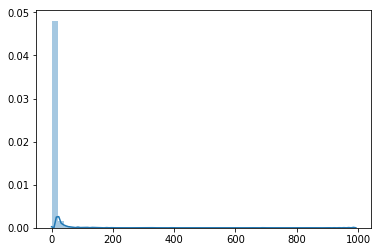

In [19]:
sns.distplot(list(X.sum(axis=0)))

In [21]:
x_col_drop = []
x_amt_nonzero = X.sum(axis=0)
for amt in x_amt_nonzero.iteritems():
    if abs(amt[1]) < 30:
        x_col_drop.append(amt[0])
        
X = X.drop(columns = x_col_drop)
X.shape

(17590, 235)

## Only get drugs shared between X and Y

In [22]:
shared_drugs = sorted(list(set(X.index) & set(Y.index)))
X = X.loc[shared_drugs]
Y = Y.loc[shared_drugs]
X = X.values
Y = Y.values

## Normalize Y

In [ ]:
Y = preprocessing.scale(Y)

## Dimentionality Reduction

In [133]:
# dr_model = decomposition.LatentDirichletAllocation(n_components=100, learning_method= 'online')
dr_model = decomposition.NMF(n_components=100, init = 'nndsvda')
# dr_model = decomposition.NMF(n_components=100)

X_dr = dr_model.fit_transform(X)

In [134]:
X_dr.shape

(5188, 100)

In [135]:
X_dr_df = pd.DataFrame(X_dr)
X_dr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.042308,0.000000,0.007577,0.000000,0.0,0.0,0.031720,0.00000,0.003762,0.0,...,0.0,0.000000,0.131632,0.0,0.000000,0.000000,0.085429,0.000000,0.279394,0.0
1,0.076589,0.051948,0.001481,0.009642,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.036819,0.000000,0.048807,0.000000,0.073638,0.0
2,0.053203,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.046222,0.224360,0.0,0.187921,0.079199,0.000000,0.063804,0.171250,0.0
3,0.000000,0.019689,0.000000,0.153053,0.0,0.0,0.159945,0.01401,0.129881,0.0,...,0.0,0.000000,0.144678,0.0,0.000000,0.025612,0.056816,0.000000,0.000000,0.0
4,0.000000,0.030536,0.070276,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.316596,0.169285,0.0,0.076502,0.000000,0.000000,0.000000,0.105931,0.0


In [136]:
X = X_dr

In [137]:
X.shape, Y.shape

((5188, 100), (5188, 978))

## Pick the classifier

In [23]:
classifier = neighbors.KNeighborsClassifier(n_neighbors = 20, metric = 'jaccard', weights = 'uniform', algorithm = 'auto', leaf_size=30)
# classifier = ensemble.AdaBoostClassifier()
# classifier = ensemble.RandomForestClassifier(n_estimators = 100, n_jobs = 7)
# classifier = neural_network.MLPClassifier()
# classifier = dummy.DummyClassifier(strategy = 'stratified')


## Run the model

In [24]:
accuracy = []
conf_mats = []
f1s = []
cv = model_selection.KFold(n_splits=4, shuffle=True)
start = time.time()
for train_idx, test_idx in cv.split(X):
    
    X_train, Y_train = X[train_idx], Y[train_idx]
    
    X_test, Y_test = X[test_idx], Y[test_idx]
    
    classifier.fit(X_train, Y_train)
    X_test = shuffle(X_test)
    Y_test_pred = classifier.predict(X_test)
    
#     acc = metrics.accuracy_score(Y_test.flatten(), Y_test_pred.flatten())
    accs = [metrics.accuracy_score(Y_test[:,j], Y_test_pred[:, j]) for j in range(Y_test.shape[1])]
    f1 = [metrics.f1_score(Y_test[:,j], Y_test_pred[:, j], average = None) for j in range(Y_test.shape[1])]
    conf_mat = [metrics.confusion_matrix(Y_test[:,j], Y_test_pred[:, j]) for j in range(Y_test.shape[1])]
    accuracy.append(accs)
    conf_mats.append(conf_mat)
    f1s.append(f1)
    
    end = time.time()
    print(end-start)

#     X_train, Y_train = X[train_idx], Y[train_idx]
    
#     # Step 1: feature selection:

#     # a k-nearest neighbor classifier to evaluate 
#     # the predictabilities of individual features in X using Y
#     knn = neighbors.KNeighborsClassifier(n_neighbors=10)
    
#     knn.fit(Y_train, X_train)
#     # Use F1-score to evaluate the predictability of x
#     x_fs_scores = metrics.f1_score(knn.predict(Y_train), 
#                                    X_train, 
#                                    average=None)
#     # drop the bottom 20% least predictable features
#     mask_features_to_keep = x_fs_scores > np.percentile(x_fs_scores, 40)
#     X_train = X_train[:, mask_features_to_keep]
    
#     # Also drop those features from X_test
#     X_test, Y_test = X[test_idx][:, mask_features_to_keep], Y[test_idx]
    
#     # Step 2: fit the multi-task regression model 
#     regressor.fit(X_train, Y_train)
#     Y_test_pred = regressor.predict(X_test)
    
#     r2s = metrics.r2_score(Y_test, Y_test_pred, multioutput='raw_values')
#     r2ss.append(r2s)
    
#     end = time.time()
#     print(end-start)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

8.245347738265991


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

16.644129037857056


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

24.76009964942932


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

32.862144947052


In [25]:
a,b,c,d,e,f,g,h,i = [],[],[],[],[],[],[],[],[]

for i1 in conf_mats:
    for i2 in i1:
        if len(i2) != 3:
            continue
        a.append(i2[0][0])
        b.append(i2[0][1])
        c.append(i2[0][2])
        d.append(i2[1][0])
        e.append(i2[1][1])
        f.append(i2[1][2])
        g.append(i2[2][0])
        h.append(i2[2][1])
        i.append(i2[2][2])
        
avga = sum(a)/len(a)
avgb = sum(b)/len(b)
avgc = sum(c)/len(c)
avgd = sum(d)/len(d)
avge = sum(e)/len(e)
avgf = sum(f)/len(f)
avgg = sum(g)/len(g)
avgh = sum(h)/len(h)
avgi = sum(i)/len(i)            

In [26]:
a_val = avga / sum([avga, avgb, avgc])
e_val = avge / sum([avgd, avge, avgf])
i_val = avgi / sum([avgg, avgh, avgi])
b_val = avgb / sum([avga, avgb, avgc])
c_val = avgc / sum([avga, avgb, avgc])
d_val = avgd / sum([avgd, avge, avgf])
f_val = avgf / sum([avgd, avge, avgf])
g_val = avgg / sum([avgg, avgh, avgi])
h_val = avgh / sum([avgg, avgh, avgi])

In [27]:
conf_mat = pd.DataFrame([[a_val,b_val,c_val],[d_val,e_val,f_val],[g_val,h_val,i_val]], columns = [1,0,-1] ,index = [1,0,-1])
conf_mat

,1,0,-1
1,0.004325,0.995590,0.000085
0,0.001388,0.998332,0.000280
-1,0.000324,0.999168,0.000508


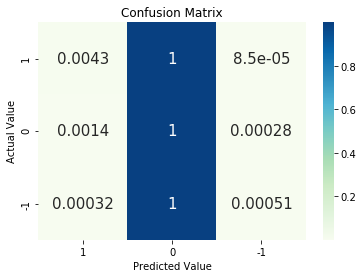

In [28]:
ax = plt.axes()
sns.heatmap(conf_mat, cmap = 'GnBu', annot = True, annot_kws={"size": 15})

# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(conf_mat)
# fig.colorbar(cax)

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Actual Value')
# ax.set_yticklabels([1,0,-1])
# ax.set_xticklabels([1,0,-1])

plt.savefig('Presentation_figures/classConMat', bbox_inches = 'tight')


In [30]:
f1s1= []
f1s0 = []
f1sn1 = []

for i1 in f1s:
    for i2 in i1:
        if len(i2) != 3:
            continue
        f1s1.append(i2[0])
        f1s0.append(i2[1])
        f1sn1.append(i2[2])

In [31]:
f1s1_avg = sum(f1s1)/len(f1s1)
f1s0_avg = sum(f1s0)/len(f1s0)
f1sn1_avg = sum(f1sn1)/len(f1sn1)

f1s1_avg,f1s0_avg,f1sn1_avg

(0.0016678453040611268, 0.9499563130487559, 0.0005014938517289145)

## Plot the Average Accuracy

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


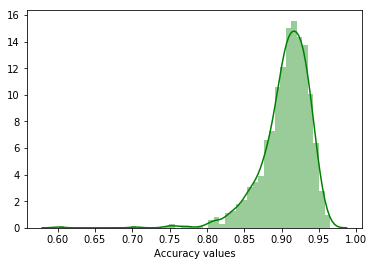

In [32]:
data = np.array(accuracy)
aver_data = np.average(data, axis=0)
sns.distplot(aver_data, color = 'green', axlabel = 'Accuracy values' )

In [33]:
avg = np.average(accuracy)
avg

0.9054572084865311

## For Gradient Boosting

In [ ]:
r2ss = []
cv = model_selection.KFold(n_splits=4, shuffle=True)
start = time.time()

for i in list(Y.columns):
    Y_i = preprocessing.scale(Y[i])
    for train_idx, test_idx in cv.split(X):
        X_train, Y_train = X[train_idx], Y_i[train_idx]
        X_test, Y_test = X[test_idx], Y_i[test_idx]

        regressor.fit(X_train, Y_train)
        Y_test_pred = regressor.predict(X_test)

        r2s = metrics.r2_score(Y_test, Y_test_pred, multioutput='raw_values')
        r2ss.append(r2s)

end = time.time()
print(end-start)

new_r2ss = [r2ss[i][0] for i in range(len(r2ss))]

In [ ]:
sns.distplot(new_r2ss)

In [ ]:
np.average(new_r2ss)

## What genes give positive R^2

In [ ]:
desired_genes = []
for array in r2ss:
    for gene in array:
        if gene >0:
            desired_genes.append(list(array).index(gene))

In [ ]:
len(set(desired_genes))

In [ ]:
print(sorted(desired_genes))

In [ ]:
cnt = Counter()
for gene in desired_genes:
    cnt[gene] += 1
dict(cnt)
keep_genes = []
for entry in cnt.items():
    if entry[1] >= 4:
        keep_genes.append(entry[0])

In [ ]:
len(keep_genes)

In [ ]:
## Keep all the gene signatures that give a positive value
columns_keep = list(set(desired_genes))

In [ ]:
## Keep gene signatures that give a positive value if they do that for 3/4 or 4/4 iterations
columns_keep = []
for i in Counter(desired_genes).most_common():
    columns_keep.append(i[0])

In [ ]:
r2ss